In [44]:
# -----------------------------
# 1. Imports
# -----------------------------
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets import load_from_disk, load_dataset, concatenate_datasets, DatasetDict
import torchmetrics
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for path joining
from IPython.lib.display import Audio as AudioDisplay

In [32]:
# -----------------------------
# 2. Configuration & Setup
# -----------------------------
SEED = 42
BATCH_SIZE = 128
NUM_WORKERS = 24
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 4e-4
MODEL_SAVE_PATH = "./best_model_2.pt"
EPOCHS=5

# --- Set Seeds for Reproducibility ---
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Disabling benchmark mode can help reproducibility
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

print(f"Using device: {DEVICE}")
print(f"Number of workers: {NUM_WORKERS}")

Using device: cuda
Number of workers: 24


In [4]:
# -----------------------------
# 3. Load Dataset
# -----------------------------
# Assuming the dataset is in a directory relative to the notebook
# Using os.path.join for better cross-platform compatibility
# DATASET_PATH = "../dataset/ds_2_noaugment_test.hf"
DATASET_PATH = "../../dataset/ds_2_noaugment_big.hf"
ONLINE_PATH = None

if ONLINE_PATH is None:
    if not os.path.exists(DATASET_PATH):
        print(f"Error: Dataset path not found at {DATASET_PATH}")
        print("Please update the DATASET_PATH variable to point to your dataset directory.")
    else:
        dataset = load_from_disk(DATASET_PATH)
        print("Dataset loaded successfully.")

        # Set format to PyTorch
        dataset = dataset.with_format("torch", columns=["audio", "label"])

        print("\nDataset splits:")
        print({k: v.shape for k, v in dataset.items()})

        print("\nDataset features:")
        print(dataset["train"].features)

Dataset loaded successfully.

Dataset splits:
{'train': (617500, 2), 'val': (78726, 2), 'test': (78483, 2)}

Dataset features:
{'audio': List(List(Value('float64'))), 'label': ClassLabel(names=['other', 'drone'])}


In [13]:
from collections import Counter
label_counts = Counter([int(i) for i in dataset["train"]["label"]])
print(label_counts)

Counter({0: 441442, 1: 176058})


In [15]:
ds = dataset["train"]
class0 = ds.filter(lambda x: x["label"] == 0, num_proc=NUM_WORKERS)
class1 = ds.filter(lambda x: x["label"] == 1, num_proc=NUM_WORKERS)

min_count = min(len(class0), len(class1))
print(f"Balancing classes to {min_count} samples each.")

Filter (num_proc=24): 100%|██████████| 617500/617500 [05:51<00:00, 1757.46 examples/s]

Balancing classes to 176058 samples each.


In [29]:
# Undersample to minority
n = min(len(class0), len(class1))
class0_ds = class0.select(range(n))
class1_ds = class1.select(range(n))

ds_train = concatenate_datasets([class0_ds, class1_ds]).shuffle(seed=SEED)

In [48]:
ds = DatasetDict()
for split in dataset.keys():
    split_ds = dataset[split]
    class0 = split_ds.filter(lambda x: x["label"] == 0, num_proc=NUM_WORKERS)
    class1 = split_ds.filter(lambda x: x["label"] == 1, num_proc=NUM_WORKERS)

    n = min(len(class0), len(class1))
    class0_ds = class0.select(range(n))
    class1_ds = class1.select(range(n))

    balanced_ds = concatenate_datasets([class0_ds, class1_ds]).shuffle(seed=SEED)
    ds[split] = balanced_ds

ds

Filter (num_proc=24): 100%|██████████| 78483/78483 [00:46<00:00, 1685.30 examples/s]


DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 352116
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 43580
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 43478
    })
})

In [46]:
ds

DatasetDict({
    
})

In [49]:
import torchaudio.transforms as T
spec_augmentations = nn.Sequential(
    # Mask up to 50 frequency bins
    T.FrequencyMasking(freq_mask_param=5),
    # Mask up to 80 time steps (frames)
    T.TimeMasking(time_mask_param=5)
)

# -----------------------------
# 2. Modified Collate Function
# -----------------------------

def collate_fn(batch, augment=False): # <-- Added an 'augment' flag
    """
    Prepares a batch for the model.
    If 'augment' is True, applies SpecAugment.
    """
    xs = [b["audio"] for b in batch]
    ys = [b["label"] for b in batch]

    # Stack spectrograms into a batch
    # (B, H, W) -> (B, 1, H, W)
    xs = torch.stack(xs, dim=0).unsqueeze(1)

    # --- APPLY AUGMENTATION ---
    # This is the new block. It only runs if augment=True
    if augment:
        xs = spec_augmentations(xs)
    # --------------------------

    # Convert labels to float and add a dimension for BCEWithLogitsLoss
    # (B,) -> (B, 1)
    ys = torch.tensor(ys, dtype=torch.float32).unsqueeze(1)

    return xs, ys

from functools import partial

train_collate_fn = partial(collate_fn, augment=True)
val_collate_fn = partial(collate_fn, augment=False)

In [50]:
# Create DataLoaders
train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=train_collate_fn, pin_memory=True)
valid_loader = DataLoader(ds["val"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=val_collate_fn, pin_memory=True)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=val_collate_fn, pin_memory=True)

print(f"\nCreated DataLoaders with Batch Size: {BATCH_SIZE}")

# Check a sample batch
try:
    sample_x, sample_y = next(iter(train_loader))
    print(f"Sample batch shape - X: {sample_x.shape}, Y: {sample_y.shape}")
except Exception as e:
    print(f"Could not load a sample batch: {e}")


Created DataLoaders with Batch Size: 128
Sample batch shape - X: torch.Size([128, 1, 1025, 16]), Y: torch.Size([128, 1])


In [51]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.prelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # The "residual" connection
        out = self.prelu(out)
        return out

class AudioResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial convolution (larger kernel can be good for spectrograms)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=(2, 1), padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.prelu = nn.PReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualBlock(32, 64, stride=2)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)

        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Dropout(0.5), # Increase dropout
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.pool1(self.prelu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Use this model instead:
model = AudioResNet().to(DEVICE)

In [52]:
# -----------------------------
# 7. Loss, Optimizer, & Metric
# -----------------------------
criterion = nn.BCEWithLogitsLoss() # Handles sigmoid internally, more stable
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Use torchmetrics for accuracy (stateful)
metric_acc = torchmetrics.classification.BinaryAccuracy().to(DEVICE)

In [53]:
best_val_acc = 0.0
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

print("\nStarting training...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    metric_acc.reset()

    # Use tqdm for progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")

    for x, y in train_pbar:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        # Forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_train_loss += loss.item() * x.size(0)
        metric_acc.update(out, y) # Update stateful metric

        train_pbar.set_postfix(loss=loss.item())

    # Step the scheduler
    scheduler.step()

    # Calculate epoch metrics
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_acc = metric_acc.compute().item()

    history["train_loss"].append(epoch_train_loss)
    history["train_acc"].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    metric_acc.reset()

    valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]", unit="batch")

    with torch.no_grad():
        for x, y in valid_pbar:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            out = model(x)
            loss = criterion(out, y)

            running_val_loss += loss.item() * x.size(0)
            metric_acc.update(out, y)

            valid_pbar.set_postfix(loss=loss.item())

    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    epoch_val_acc = metric_acc.compute().item()

    history["val_loss"].append(epoch_val_loss)
    history["val_acc"].append(epoch_val_acc)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.4f}")

    # Save the best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✅ Saved new best model to {MODEL_SAVE_PATH} (Val Acc: {best_val_acc:.4f})")

print("\nTraining complete.")


Starting training...


Epoch 1/5 [Valid]: 100%|██████████| 341/341 [00:29<00:00, 11.41batch/s, loss=0.0186]



Epoch 1/5 | Train Loss: 0.1352 | Train Acc: 0.9501 | Val Loss: 0.1002 | Val Acc: 0.9694
✅ Saved new best model to ./best_model_2.pt (Val Acc: 0.9694)


Epoch 2/5 [Valid]: 100%|██████████| 341/341 [00:30<00:00, 11.05batch/s, loss=0.00527]



Epoch 2/5 | Train Loss: 0.0562 | Train Acc: 0.9819 | Val Loss: 0.0834 | Val Acc: 0.9818
✅ Saved new best model to ./best_model_2.pt (Val Acc: 0.9818)


Epoch 3/5 [Valid]: 100%|██████████| 341/341 [00:29<00:00, 11.53batch/s, loss=0.133] 



Epoch 3/5 | Train Loss: 0.0356 | Train Acc: 0.9888 | Val Loss: 0.1520 | Val Acc: 0.9566


Epoch 4/5 [Valid]: 100%|██████████| 341/341 [00:29<00:00, 11.55batch/s, loss=0.0742] 



Epoch 4/5 | Train Loss: 0.0236 | Train Acc: 0.9928 | Val Loss: 0.0781 | Val Acc: 0.9811


Epoch 5/5 [Valid]: 100%|██████████| 341/341 [00:29<00:00, 11.53batch/s, loss=0.161]  


Epoch 5/5 | Train Loss: 0.0165 | Train Acc: 0.9950 | Val Loss: 0.1162 | Val Acc: 0.9718

Training complete.


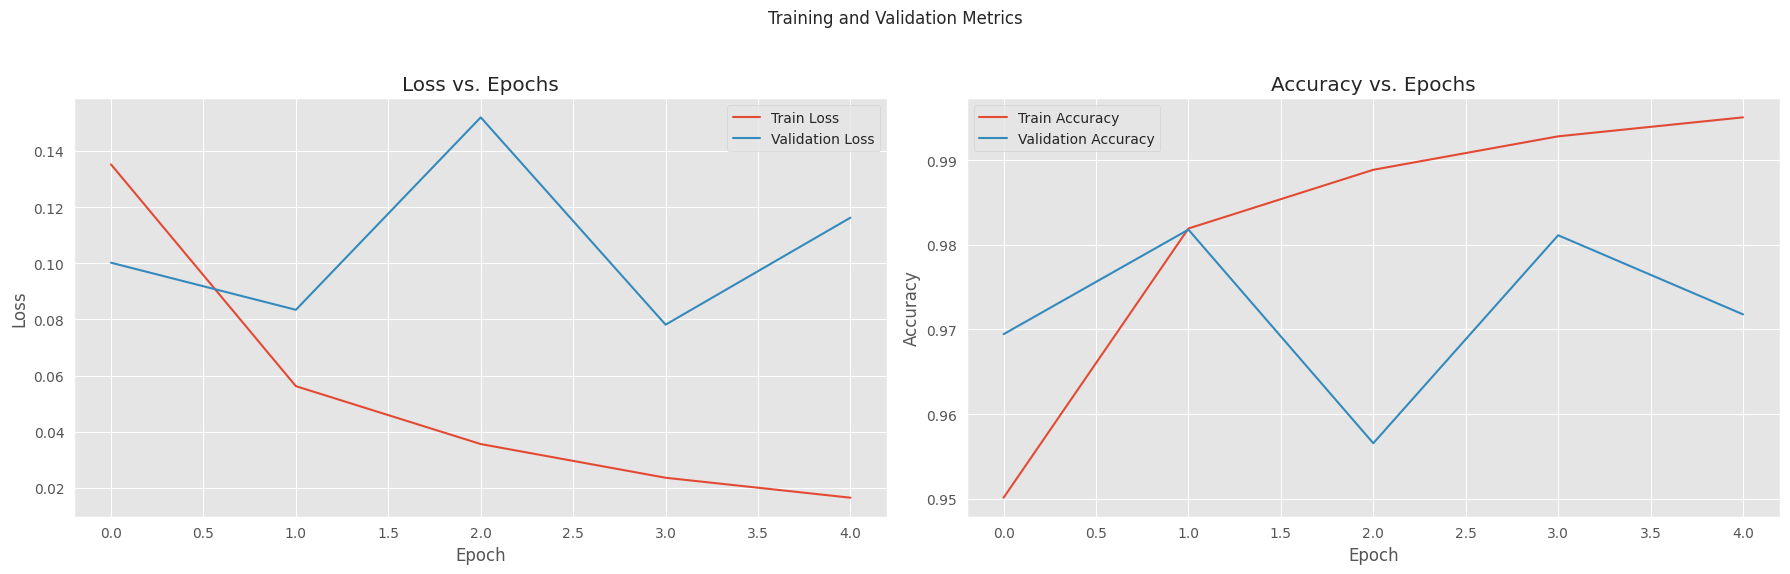

In [54]:
# -----------------------------
# 9. Plot Training History
# -----------------------------
if history["train_loss"]: # Check if training actually ran
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Loss
    ax1.plot(history["train_loss"], label="Train Loss")
    ax1.plot(history["val_loss"], label="Validation Loss")
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_acc"], label="Train Accuracy")
    ax2.plot(history["val_acc"], label="Validation Accuracy")
    ax2.set_title("Accuracy vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.suptitle("Training and Validation Metrics")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [55]:
print(f"Loading best model from {MODEL_SAVE_PATH}...")
model = AudioResNet().to(DEVICE)
model.load_state_dict(torch.load("best_model_2.pt", map_location=DEVICE))
model.eval()
print("Loaded best model and set to eval mode.")

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        logits = model(x)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply 0.5 threshold for predictions

        all_preds.extend(preds.cpu().numpy().flatten())
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(y.cpu().numpy().flatten())

print("\nTest evaluation complete.")

Loading best model from ./best_model_2.pt...
Loaded best model and set to eval mode.


Testing: 100%|██████████| 340/340 [00:27<00:00, 12.22it/s]


Test evaluation complete.



Test Accuracy: 98.25%

Classification Report:
              precision    recall  f1-score   support

       other      0.972     0.994     0.983     21739
       drone      0.993     0.972     0.982     21739

    accuracy                          0.983     43478
   macro avg      0.983     0.983     0.983     43478
weighted avg      0.983     0.983     0.983     43478



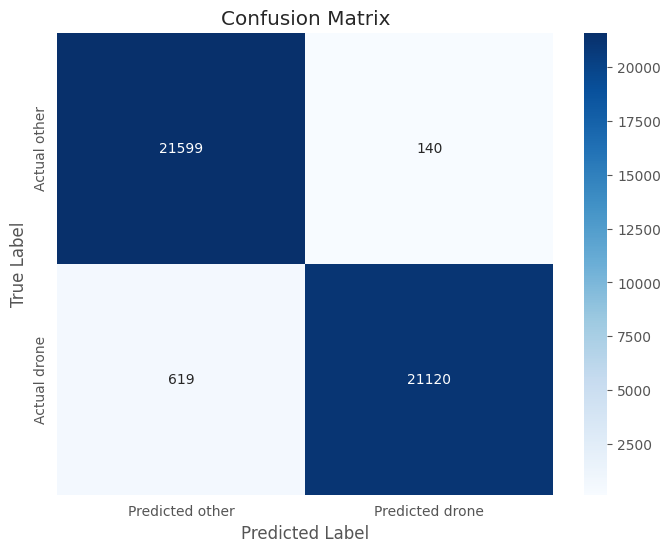


Results DataFrame head:
   true_label  pred_label    confidence
0         0.0         0.0  9.449271e-07
1         1.0         1.0  9.999998e-01
2         0.0         0.0  4.070134e-04
3         1.0         1.0  9.999983e-01
4         0.0         0.0  1.442060e-03


In [56]:
# -----------------------------
# 11. Analyze Test Results
# -----------------------------
# --- Overall Accuracy ---
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# --- Classification Report ---
# Assuming 0 is 'fake' and 1 is 'real', or 'Class 0' and 'Class 1'
# Adjust target_names if you have the actual class names
try:
    # Try to get names from dataset features if they exist
    target_names = dataset["train"].features["label"].names
    if len(target_names) != 2: # Fallback if it's not binary
        target_names = ["Class 0", "Class 1"]
except:
    target_names = ["Class 0", "Class 1"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Predicted {target_names[0]}", f"Predicted {target_names[1]}"],
            yticklabels=[f"Actual {target_names[0]}", f"Actual {target_names[1]}"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Store results in a DataFrame (optional) ---
df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

print("\nResults DataFrame head:")
print(df_results.head())

In [57]:
from matplotlib import pyplot as plt
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")

def swap_labels(example):
    example["label"] = 1 - example["label"]   # flips 0 ↔ 1
    return example

ds_test_online = ds_test_online.map(swap_labels)
ds_test_online2 = ds_test_online2.map(swap_labels)

def convert_to_linear_spectrogram(batch):
    all_linear_db = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        data = np.array(audio["array"])

        # ---- FIX: convertir en float32 ----
        data = data.astype(np.float32)

        # Normalisation optionnelle (mais recommandée)
        # data = data / np.max(np.abs(data) + 1e-8)

        # Compute STFT
        stft = librosa.stft(data, n_fft=2048, hop_length=512)

        # Compute magnitude
        magnitude = np.abs(stft)

        # Convert to dB
        linear_db = librosa.amplitude_to_db(magnitude, ref=np.max)

        all_linear_db.append(linear_db)
        all_labels.append(label)

    return {
        "audio": all_linear_db,
        "label": all_labels,
    }

import librosa

NUM_PROC = 4
LABELS = dataset["train"].features["label"]

ds_test_online_spec = ds_test_online.map(
    convert_to_linear_spectrogram,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online.column_names,
).with_format("torch")

ds_test_online2_spec = ds_test_online2.map(
    convert_to_linear_spectrogram,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=ds_test_online2.column_names,
).with_format("torch")

test_loader1 = DataLoader(ds_test_online_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

test_loader2 = DataLoader(ds_test_online2_spec, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

y_true1, y_pred1, y_true2, y_pred2 = [], [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader1, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred1.extend(preds.cpu().numpy())
        y_true1.extend(y.cpu().numpy())

with torch.no_grad():
    for x, y in tqdm(test_loader2, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_pred2.extend(preds.cpu().numpy())
        y_true2.extend(y.cpu().numpy())



Testing: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = float("nan")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "confusion_matrix": cm,
    }

metrics1 = compute_metrics(y_true1, y_pred1)
metrics2 = compute_metrics(y_true2, y_pred2)

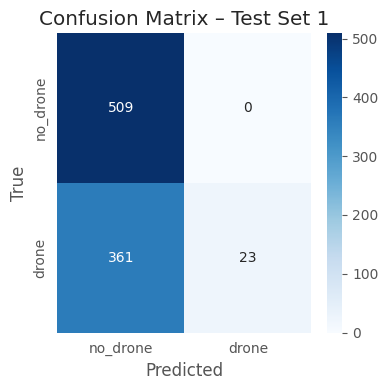

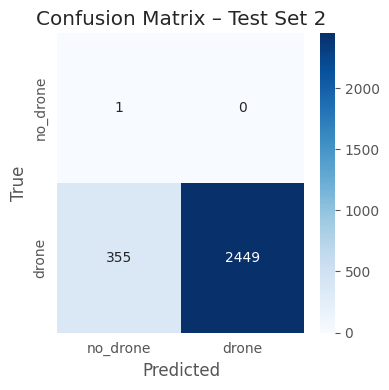

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["no_drone", "drone"]

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(metrics1["confusion_matrix"], "Confusion Matrix – Test Set 1")
plot_confusion(metrics2["confusion_matrix"], "Confusion Matrix – Test Set 2")